In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.3.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='C:\\Users\\tulas\\tensorflow_datasets\\kitti\\3.3.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/file_name': Text(shape=(), dtype=string),
        'objects': Sequence({
            'al

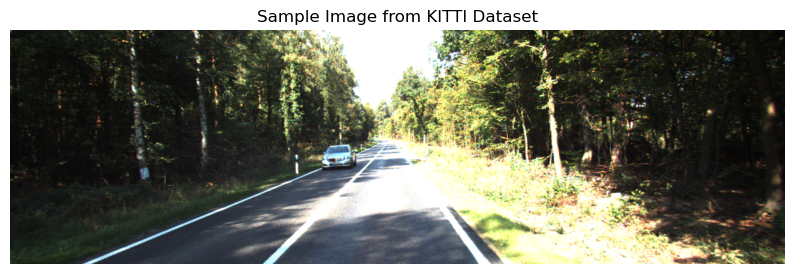

In [3]:
dataset, info = tfds.load('kitti', split='train', with_info=True)
print(info)
example = next(iter(dataset))
image = example['image'].numpy()
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title("Sample Image from KITTI Dataset")
plt.axis("off")
plt.show()


Bounding Box 0: Label=Car, Coordinates: (494.9, 160.7) -> (557.1, 202.2)


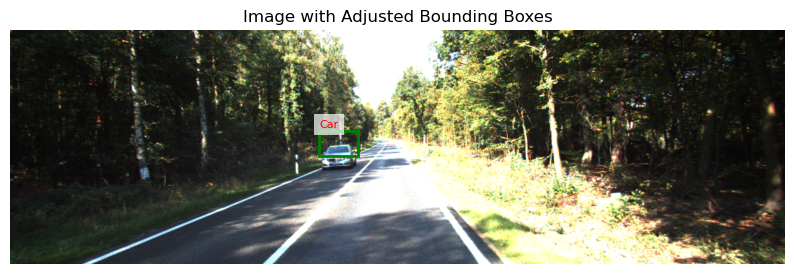

In [4]:
import matplotlib.patches as patches

def visualize_bounding_boxes_adjusted(example, info, y_offset=5):
    image = example['image'].numpy()
    bboxes = example['objects']['bbox'].numpy()  # [ymin, xmin, ymax, xmax]
    labels = example['objects']['type'].numpy()
    
    height, width, _ = image.shape

    fig, ax = plt.subplots(1, figsize=(10, 6))
    ax.imshow(image)

    for i, (bbox, label) in enumerate(zip(bboxes, labels)):
        ymin, xmin, ymax, xmax = bbox
        xmin_scaled = xmin * width
        # Add a y_offset (in pixels) to shift the box downward
        ymin_scaled = (ymin * height) + y_offset
        xmax_scaled = xmax * width
        ymax_scaled = (ymax * height) + y_offset

        rect = patches.Rectangle(
            (xmin_scaled, ymin_scaled),
            xmax_scaled - xmin_scaled,
            ymax_scaled - ymin_scaled,
            linewidth=2,
            edgecolor='green',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        label_str = info.features['objects']['type'].int2str(label)
       
        ax.text(
            xmin_scaled, ymin_scaled - 5,
            label_str,
            color='red',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )
        print(f"Bounding Box {i}: Label={label_str}, Coordinates: ({xmin_scaled:.1f}, {ymin_scaled:.1f}) -> ({xmax_scaled:.1f}, {ymax_scaled:.1f})")

    ax.set_title("Image with Adjusted Bounding Boxes")
    ax.axis("off")
    plt.show()


# Use the function on a sample example with a 10-pixel vertical offset:
example = next(iter(dataset))
visualize_bounding_boxes_adjusted(example, info, y_offset=10)




In [5]:
import os
from sklearn.model_selection import train_test_split

# Load the KITTI dataset (training split)
dataset = tfds.load('kitti', split='train')
# 'info' holds the metadata (useful for converting class ids to names, etc.)
_, info = tfds.load('kitti', split='train', with_info=True)

# Define base directories for the YOLO-formatted dataset
base_dir = "yolo_kitti"
image_dir = os.path.join(base_dir, "images")
label_dir = os.path.join(base_dir, "labels")

# Create directories for train, validation, and test splits
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(image_dir, split), exist_ok=True)
    os.makedirs(os.path.join(label_dir, split), exist_ok=True)

# Function to convert a bounding box from KITTI to YOLO format
def convert_bbox_to_yolo(bbox, img_width, img_height):
    """
    Converts a bounding box from KITTI format (ymin, xmin, ymax, xmax) to YOLO format:
    (x_center, y_center, width, height), all normalized.
    """
    ymin, xmin, ymax, xmax = bbox
    x_center = (xmin + xmax) / 2.0
    y_center = (ymin + ymax) / 2.0
    bbox_width = xmax - xmin
    bbox_height = ymax - ymin
    return x_center, y_center, bbox_width, bbox_height

# Lists to store image data and labels
images = []
labels = []

# Process each example in the dataset
for idx, example in enumerate(dataset):
    image = example['image'].numpy()
    bboxes = example['objects']['bbox'].numpy()  # List of bounding boxes for the image
    class_ids = example['objects']['type'].numpy()  # Class ids corresponding to each bbox

    height, width, _ = image.shape

    # Retrieve the image filename if available; otherwise, generate one
    if 'image/file_name' in example:
        image_name = example['image/file_name'].numpy().decode('utf-8')
    else:
        image_name = f"img_{idx:05d}.jpg"
    images.append((image, image_name))

    # Create the label lines for each object in the image
    label_lines = []
    for bbox, class_id in zip(bboxes, class_ids):
        # Convert KITTI bbox to YOLO format (normalized)
        x_center, y_center, bbox_width, bbox_height = convert_bbox_to_yolo(bbox, width, height)
        # Format: class x_center y_center width height (all normalized to 1.0)
        label_line = f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"
        label_lines.append(label_line)
    labels.append((image_name, "\n".join(label_lines)))

# Split the dataset into train (80%), and a temporary test (20%) set.
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42
)
# Further split the temporary test set into validation and test sets (50/50 split)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    test_imgs, test_labels, test_size=0.5, random_state=42
)

# Helper function to save images and label files in the corresponding directories
def save_data(images, labels, split):
    for (image, image_name), (label_name, label_data) in zip(images, labels):
        # Save image (using TensorFlow's utility, which supports various formats)
        img_path = os.path.join(image_dir, split, image_name)
        tf.keras.utils.save_img(img_path, image)
        # Save label file (.txt) with the same basename as the image
        label_file = os.path.splitext(image_name)[0] + ".txt"
        label_path = os.path.join(label_dir, split, label_file)
        with open(label_path, "w") as f:
            f.write(label_data)

# Save the data into train, validation, and test directories
save_data(train_imgs, train_labels, "train")
save_data(val_imgs, val_labels, "val")
save_data(test_imgs, test_labels, "test")

print("Dataset conversion to YOLO format complete!")


Dataset conversion to YOLO format complete!


In [6]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

C:\Users\tulas\anaconda3\envs\kitti_project39\notebooks\yolov5


fatal: destination path 'yolov5' already exists and is not an empty directory.


In [7]:
%cd yolov5

[WinError 2] The system cannot find the file specified: 'yolov5'
C:\Users\tulas\anaconda3\envs\kitti_project39\notebooks\yolov5


In [8]:
%cd C:\Users\tulas\anaconda3\envs\kitti_project39\notebooks\yolov5

C:\Users\tulas\anaconda3\envs\kitti_project39\notebooks\yolov5


In [ ]:
!python train.py --img 640 --batch 16 --epochs 10 --data data/kitti.yaml --weights yolov5s.pt --project kitti_training --name yolov5s_kitti

In [ ]:
!python detect.py --weights kitti_training/yolov5s_kitti/weights/best.pt --img 640 --conf 0.25 --source /test_images